In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import joblib # to save the scaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model #to save the model
from tensorflow.keras.layers import Input, Dense, Lambda
from tensorflow.keras import regularizers

from scikeras.wrappers import KerasRegressor
from sklearn.model_selection import RandomizedSearchCV
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

from pandas.plotting import autocorrelation_plot
import random

# Set the random seed for reproducibility
seed = 42
np.random.seed(seed)
random.seed(seed)
tf.random.set_seed(seed)

from commons import create_sequences, load_data, add_advanced_time_features, add_lag_features, scale_data, filter_data_by_date, filter_last_x_days, plot_anomalies
from commons import timesteps, anomaly_trashold  # Number of lags. Any lag longer then 100 will theoreticaly not work since we apply this model to the last 100 days for anomaly detection.


In [2]:

# Define a function to create the autoencoder model
# Model specific code
def create_autoencoder_model(model_type="basic", input_dim=10, encoding_dim=4, activation='relu', learning_rate=0.001):
    """
    Creates different types of autoencoders based on the `model_type` argument.
    
    Args:
        model_type (str): The type of autoencoder ('basic', 'deep', 'conv', 'variational').
        input_dim (int): Number of input features (dimensionality).
        encoding_dim (int): Bottleneck dimension (number of encoding neurons).
        activation (str): Activation function to use.
        learning_rate (float): Learning rate for the optimizer.

    Returns:
        Model: Keras autoencoder model.
    """
    
    if model_type == "basic":
        # Basic autoencoder
        input_layer = Input(shape=(input_dim,))
        encoded = Dense(encoding_dim, activation=activation)(input_layer)
        decoded = Dense(input_dim, activation='linear')(encoded)
        autoencoder = Model(inputs=input_layer, outputs=decoded)
    
    elif model_type == "deep":
        # Deep autoencoder with multiple encoding/decoding layers
        input_layer = Input(shape=(input_dim,))
        encoded = Dense(encoding_dim*2, activation=activation)(input_layer)
        encoded = Dense(encoding_dim, activation=activation)(encoded)
        decoded = Dense(encoding_dim*2, activation=activation)(encoded)
        decoded = Dense(input_dim, activation='linear')(decoded)
        autoencoder = Model(inputs=input_layer, outputs=decoded)
    
    
    elif model_type == "variational":
        # Variational autoencoder (VAE)
        def sampling(args):
            z_mean, z_log_var = args
            batch = tf.shape(z_mean)[0]
            dim = tf.shape(z_mean)[1]
            epsilon = K.random_normal(shape=(batch, dim))
            return z_mean + K.exp(0.5 * z_log_var) * epsilon
        
        latent_dim = encoding_dim
        input_layer = Input(shape=(input_dim,))
        encoded = Dense(encoding_dim, activation=activation)(input_layer)
        z_mean = Dense(latent_dim)(encoded)
        z_log_var = Dense(latent_dim)(encoded)
        
        z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])
        decoder_h = Dense(encoding_dim, activation=activation)
        decoder_mean = Dense(input_dim, activation='linear')
        
        h_decoded = decoder_h(z)
        x_decoded_mean = decoder_mean(h_decoded)
        
        autoencoder = Model(inputs=input_layer, outputs=x_decoded_mean)

        # Custom loss: reconstruction loss + KL divergence
        reconstruction_loss = MeanSquaredError()(input_layer, x_decoded_mean)
        kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
        vae_loss = K.mean(reconstruction_loss + kl_loss)
        autoencoder.add_loss(vae_loss)
        
 
    else:
        raise ValueError("Invalid model_type! Choose from 'basic', 'deep', 'variational'.")

    optimizer = Adam(learning_rate=learning_rate)
    autoencoder.compile(optimizer=optimizer, loss='mean_squared_error')
    
    return autoencoder

# Function to create RandomizedSearchCV with the model type as a parameter
def get_random_search_autoencoder(train_data, model_types=['basic', 'deep'], input_dim=10):
    param_dist = {
        'model__model_type': model_types,   # Choose between different types of autoencoders
        'model__encoding_dim': [4, 8, 16],  # Different bottleneck dimensions
        'model__activation': ['relu', 'tanh', 'sigmoid'],  # Different activation functions
        'model__learning_rate': [0.001, 0.0001, 0.00001],  # Learning rates to try
        'batch_size': [32, 64, 128],  # Batch size
        'epochs': [50, 100, 150]  # Number of epochs
    }

    # Wrap the model using SciKeras's KerasRegressor
    autoencoder = KerasRegressor(model=create_autoencoder_model, input_dim=input_dim)

    # Initialize RandomizedSearchCV
    random_search = RandomizedSearchCV(
        estimator=autoencoder, 
        param_distributions=param_dist, 
        n_iter=10,  # Try 10 different configurations
        scoring='neg_mean_squared_error', 
        cv=3,  # 3-fold cross-validation
        verbose=0  # Set verbosity level to 0
    )
    
    return random_search




In [3]:
# Now that I have the correct data file, let's load it and inspect the contents for the refactored workflow.

# Load the dataset
data_file_path = 'SolarEdge_Tageswerte_Modified.csv'

# Read the dataset
data = load_data(data_file_path)

# Display the first few rows of the dataset to understand its structure
data.head()


,Time,Inv 1 AC-Leistung (W)
0,04.12.2019,3309.0420
1,05.12.2019,167.5701
2,06.12.2019,1459.9454
3,07.12.2019,1349.0909
4,08.12.2019,2480.6001


In [4]:
# Count the number of NaN values in each column
nan_counts = data.isna().sum()
print(nan_counts)


Time                     0
Inv 1 AC-Leistung (W)    0
dtype: int64


In [5]:
#Handle Missing Values: Use interpolation or forward/backward filling.
# Ensure that object-type columns are inferred as their proper types (e.g., float, int, etc.)
data = data.infer_objects(copy=False)

# Now apply interpolation on the DataFrame
data.interpolate(method='linear', inplace=True)
data.ffill(inplace=True)

C:\Users\b50578\AppData\Local\Temp\ipykernel_7604\730496189.py:6: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  data.interpolate(method='linear', inplace=True)


In [6]:
print(data.columns)

Index(['Time', 'Inv 1 AC-Leistung (W)'], dtype='object')


In [7]:
# Example usage on your dataset
data_with_time_features = add_advanced_time_features(data, 'Time')

# Display the dataset with the newly added time-based features
data_with_time_features.head()

,Time,Inv 1 AC-Leistung (W),hour,day,day_of_week,week_of_year,month,is_weekend
0,2019-12-04,3309.0420,0,4,2,49,12,0
1,2019-12-05,167.5701,0,5,3,49,12,0
2,2019-12-06,1459.9454,0,6,4,49,12,0
3,2019-12-07,1349.0909,0,7,5,49,12,1
4,2019-12-08,2480.6001,0,8,6,49,12,1


In [8]:
# Count the number of NaN values in each column
nan_counts = data_with_time_features.isna().sum()
print(nan_counts)


Time                     0
Inv 1 AC-Leistung (W)    0
hour                     0
day                      0
day_of_week              0
week_of_year             0
month                    0
is_weekend               0
dtype: int64


In [9]:
# Example usage of the function
#timesteps = 3  # I moved it up 
data_with_lags = add_lag_features(data_with_time_features, target_column='Inv 1 AC-Leistung (W)', n_lags=timesteps)

# Display the dataset with added lag features
data_with_lags.head()

,Time,Inv 1 AC-Leistung (W),hour,day,day_of_week,week_of_year,month,is_weekend,lag_1,lag_2,lag_3,lag_4
4,2019-12-08,2480.6001,0,8,6,49,12,1,1349.0909,1459.9454,167.5701,3309.0420
5,2019-12-09,1253.6415,0,9,0,50,12,0,2480.6001,1349.0909,1459.9454,167.5701
6,2019-12-10,2156.0090,0,10,1,50,12,0,1253.6415,2480.6001,1349.0909,1459.9454
7,2019-12-11,2775.5364,0,11,2,50,12,0,2156.0090,1253.6415,2480.6001,1349.0909
8,2019-12-12,264.2212,0,12,3,50,12,0,2775.5364,2156.0090,1253.6415,2480.6001


In [10]:
data_with_lags

,Time,Inv 1 AC-Leistung (W),hour,day,day_of_week,week_of_year,month,is_weekend,lag_1,lag_2,lag_3,lag_4
4,2019-12-08,2480.6001,0,8,6,49,12,1,1349.0909,1459.9454,167.5701,3309.0420
5,2019-12-09,1253.6415,0,9,0,50,12,0,2480.6001,1349.0909,1459.9454,167.5701
6,2019-12-10,2156.0090,0,10,1,50,12,0,1253.6415,2480.6001,1349.0909,1459.9454
7,2019-12-11,2775.5364,0,11,2,50,12,0,2156.0090,1253.6415,2480.6001,1349.0909
8,2019-12-12,264.2212,0,12,3,50,12,0,2775.5364,2156.0090,1253.6415,2480.6001
...,...,...,...,...,...,...,...,...,...,...,...,...
1522,2024-02-09,928.9344,0,9,4,6,2,0,2121.3120,1854.0640,1850.7222,1186.2347
1523,2024-02-10,1124.4678,0,10,5,6,2,1,928.9344,2121.3120,1854.0640,1850.7222
1524,2024-02-11,313.8197,0,11,6,6,2,1,1124.4678,928.9344,2121.3120,1854.0640
1525,2024-02-12,1279.3521,0,12,0,7,2,0,313.8197,1124.4678,928.9344,2121.3120


In [11]:
scaler = StandardScaler()

# Apply scaling to the data
scaled_data, scaled_feature_names = scale_data(
    scaler=scaler, 
    data=data_with_lags, 
    target_column='Inv 1 AC-Leistung (W)', 
    n_lags=timesteps  # Dynamic number of lags
)

print("Scaled feature names:", scaled_feature_names)


Scaled feature names: ['Inv 1 AC-Leistung (W)', 'lag_1', 'lag_2', 'lag_3', 'lag_4']


In [12]:
# Filter the scaled data by date
train_data_filtered = filter_data_by_date(
    data=scaled_data, 
    time_column='Time', 
    max_date_str='2024-02-15', 
    days_offset=200, 
    n_years_for_training=3
)

train_data_filtered


,Time,Inv 1 AC-Leistung (W),hour,day,day_of_week,week_of_year,month,is_weekend,lag_1,lag_2,lag_3,lag_4
433,2021-02-15,1.698100,0,15,0,7,2,0,1.692281,1.224920,0.327799,1.458606
434,2021-02-16,0.612384,0,16,1,7,2,0,1.697784,1.692204,1.225181,0.327181
435,2021-02-17,0.386265,0,17,2,7,2,0,0.612113,1.697707,1.692753,1.224837
436,2021-02-18,1.455198,0,18,3,7,2,0,0.386004,0.611789,1.698261,1.692552
437,2021-02-19,0.792457,0,19,4,7,2,0,1.454892,0.385628,0.611670,1.698061
...,...,...,...,...,...,...,...,...,...,...,...,...
1158,2023-02-10,1.297119,0,10,4,6,2,0,1.240866,-0.519373,1.330722,-0.389654
1159,2023-02-11,0.528399,0,11,5,6,2,1,1.296819,1.240685,-0.520192,1.330410
1160,2023-02-12,0.814513,0,12,6,6,2,1,0.528131,1.296651,1.240955,-0.521069
1161,2023-02-13,1.347862,0,13,0,7,2,0,0.814233,0.527788,1.296956,1.240616


In [13]:
train_data_filtered.columns

Index(['Time', 'Inv 1 AC-Leistung (W)', 'hour', 'day', 'day_of_week',
       'week_of_year', 'month', 'is_weekend', 'lag_1', 'lag_2', 'lag_3',
       'lag_4'],
      dtype='object')

In [14]:
last_x_days_data = filter_last_x_days(data_with_lags, time_column='Time', max_date_str='2024-02-15', days_offset=200)

# Display the filtered data
last_x_days_data

,Time,Inv 1 AC-Leistung (W),hour,day,day_of_week,week_of_year,month,is_weekend,lag_1,lag_2,lag_3,lag_4
1329,2023-07-31,0.173343,0,31,0,31,7,0,0.585385,0.713966,0.837300,0.773399
1330,2023-08-01,-1.386909,0,1,1,31,8,0,0.173091,0.585054,0.713910,0.836837
1331,2023-08-02,-0.046042,0,2,2,31,8,0,-1.387095,0.172667,0.584919,0.713410
1332,2023-08-03,-1.474263,0,3,3,31,8,0,-0.046284,-1.387875,0.172276,0.584379
1333,2023-08-04,-1.540768,0,4,4,31,8,0,-1.474446,-0.046759,-1.389232,0.171610
...,...,...,...,...,...,...,...,...,...,...,...,...
1522,2024-02-09,-1.125458,0,9,4,6,2,0,-0.167301,-0.382649,-0.386072,-0.921595
1523,2024-02-10,-0.968295,0,10,5,6,2,1,-1.125655,-0.167804,-0.383383,-0.386908
1524,2024-02-11,-1.619867,0,11,6,6,2,1,-0.968499,-1.126376,-0.168405,-0.384219
1525,2024-02-12,-0.843804,0,12,0,7,2,0,-1.620044,-0.969184,-1.127571,-0.169175


In [15]:
#data_with_lags
last_x_days_data.size

2376

In [16]:
# Drop the 'Time' column before fitting the model, as IsolationForest only accepts numeric features
train_data_filtered_numeric = train_data_filtered.drop(columns=['Time'])
#train_data_filtered['Time'] = pd.to_numeric(train_data_filtered['Time'])
print(train_data_filtered_numeric.dtypes)

Inv 1 AC-Leistung (W)    float64
hour                       int32
day                        int32
day_of_week                int32
week_of_year              UInt32
month                      int32
is_weekend                 int64
lag_1                    float64
lag_2                    float64
lag_3                    float64
lag_4                    float64
dtype: object


In [17]:
# Run RandomizedSearchCV to find the best autoencoder type and hyperparameters
random_search = get_random_search_autoencoder(train_data_filtered_numeric, model_types=['basic', 'deep', 'conv', 'variational','lstm'], input_dim=train_data_filtered_numeric.shape[1])

# Fit the RandomizedSearchCV object
random_search.fit(train_data_filtered_numeric, train_data_filtered_numeric)

# Best parameters
print("Best Parameters:", random_search.best_params_)

Epoch 1/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 130.4075  
Epoch 2/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 129.8747 
Epoch 3/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 129.3410 
Epoch 4/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 128.8065 
Epoch 5/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 128.2730
Epoch 6/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 127.7425 
Epoch 7/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 127.2157 
Epoch 8/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 126.6933 
Epoch 9/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 126.1763 
Epoch 10/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 125.6657 
Epoch 11/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 125.1614 
Epoch 12/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 124.6627 
Epoch 13/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 124.1685 
Epoch 14/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 123.6782 
Epoch 15/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss

C:\Users\b50578\.conda\envs\PhD\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
9 fits failed out of a total of 30.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
6 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\b50578\.conda\envs\PhD\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\b50578\.conda\envs\PhD\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "C:\Users\b50578\.conda\envs\PhD\Lib\site-packages\scikeras\wrappers.py", line 925, in _fit
    X, y = self._initialize(X, y)
           ^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\b

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 128.6783  
Epoch 2/150
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 123.7589 
Epoch 3/150
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 119.0821 
Epoch 4/150
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 114.6522
Epoch 5/150
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 110.4642 
Epoch 6/150
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 106.5037 
Epoch 7/150
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 102.7526
Epoch 8/150
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 99.1750 
Epoch 9/150
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 95.7431 
Epoch 10/150
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 92.4034 
Epoch 11/150
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 89.1038 
Epoch 12/150
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 85.8147 
Epoch 13/150
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 82.4913 
Epoch 14/150
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 79.0594 
Epoch 15/150
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 75.5087 
Epoch 16/1

In [18]:
# Train the final model with best hyperparameters
best_params = random_search.best_params_

# Get the number of input features (assuming train_data is already defined)
input_dim = train_data_filtered_numeric.shape[1]
best_params

{'model__model_type': 'basic',
 'model__learning_rate': 0.001,
 'model__encoding_dim': 8,
 'model__activation': 'relu',
 'epochs': 150,
 'batch_size': 128}

In [19]:
# Create the autoencoder model using the best parameters
autoencoder_model = create_autoencoder_model(
    input_dim=input_dim,  # Pass the input_dim as a required argument
    encoding_dim=best_params['model__encoding_dim'],
    activation=best_params['model__activation'],
    learning_rate=best_params['model__learning_rate']
)

# Train the final model with the best hyperparameters
history = autoencoder_model.fit(
    train_data_filtered_numeric, train_data_filtered_numeric,
    epochs=best_params['epochs'],
    batch_size=best_params['batch_size'],
    shuffle=False, #shuffle data for time series is not wanted
    #validation_data=(val_data, val_data),
    validation_split=0.2, # 20% of training data is for validation if not passed explicitly as in code live before
    verbose=0 # 0- no output, 1-provide the output, 2-batch output
)

# Print the history of the final model
print("Final model trained with the best hyperparameters.")

Final model trained with the best hyperparameters.


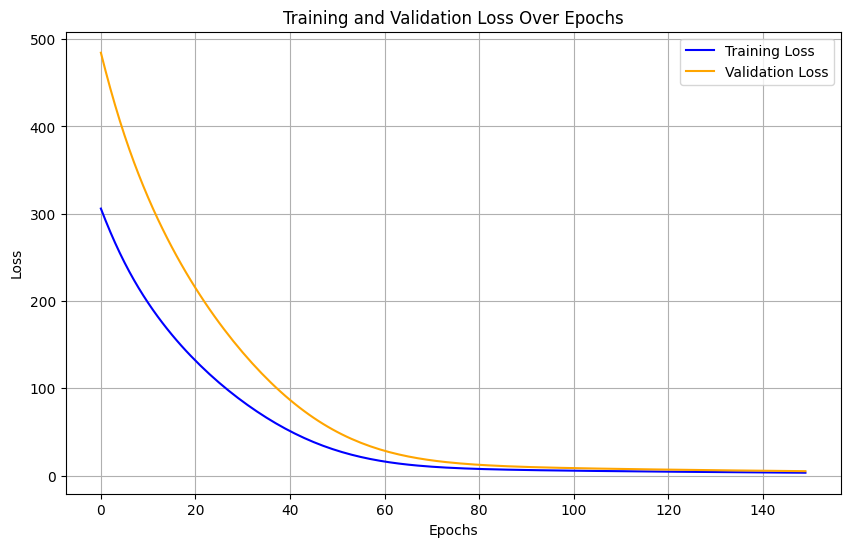

In [20]:

# Function to plot training and validation loss
def plot_training_history(history):
    """
    Plots the training and validation loss over epochs.
    
    Parameters:
    - history: Keras History object containing training/validation loss values.
    """
    plt.figure(figsize=(10, 6))
    
    # Plot training loss
    plt.plot(history.history['loss'], label='Training Loss', color='blue')
    
    # Plot validation loss
    if 'val_loss' in history.history:
        plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
    
    # Labels and title
    plt.title('Training and Validation Loss Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

# Example usage of the function to plot training and validation loss
plot_training_history(history)  # 'history' comes from the autoencoder model's training process


In [21]:
trained_feature_names = train_data_filtered_numeric.columns
# Ensure you are selecting only the same features in last_x_days_data
last_x_days_data_filtered = last_x_days_data[trained_feature_names]
last_x_days_data_filtered

,Inv 1 AC-Leistung (W),hour,day,day_of_week,week_of_year,month,is_weekend,lag_1,lag_2,lag_3,lag_4
1329,0.173343,0,31,0,31,7,0,0.585385,0.713966,0.837300,0.773399
1330,-1.386909,0,1,1,31,8,0,0.173091,0.585054,0.713910,0.836837
1331,-0.046042,0,2,2,31,8,0,-1.387095,0.172667,0.584919,0.713410
1332,-1.474263,0,3,3,31,8,0,-0.046284,-1.387875,0.172276,0.584379
1333,-1.540768,0,4,4,31,8,0,-1.474446,-0.046759,-1.389232,0.171610
...,...,...,...,...,...,...,...,...,...,...,...
1522,-1.125458,0,9,4,6,2,0,-0.167301,-0.382649,-0.386072,-0.921595
1523,-0.968295,0,10,5,6,2,1,-1.125655,-0.167804,-0.383383,-0.386908
1524,-1.619867,0,11,6,6,2,1,-0.968499,-1.126376,-0.168405,-0.384219
1525,-0.843804,0,12,0,7,2,0,-1.620044,-0.969184,-1.127571,-0.169175


In [22]:
# 1. Use the trained autoencoder to reconstruct the data
reconstructed_data = autoencoder_model.predict(last_x_days_data_filtered)

# 2. Calculate the reconstruction error (difference between input and reconstructed data)
reconstruction_error = np.mean(np.abs(last_x_days_data_filtered - reconstructed_data), axis=1)

# 3. Set a threshold for the anomaly (you can use a statistical method or heuristic)
# Here we are using the 95th percentile of reconstruction error as the threshold
threshold = np.percentile(reconstruction_error, anomaly_trashold)

# 4. Label data points as anomalies if their reconstruction error is greater than the threshold
last_x_days_data.loc[:, 'anomaly'] = reconstruction_error > threshold  # Use .loc[] to avoid the warning

# 5. Convert boolean anomaly values (True/False) to integers (1 for anomaly, 0 for normal)
last_x_days_data.loc[:, 'anomaly'] = last_x_days_data['anomaly'].astype(int)  # Use .loc[] to avoid the warning

# 6. Display the results
print(last_x_days_data.head())

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
           Time  Inv 1 AC-Leistung (W)  hour  day  day_of_week  week_of_year  \
1329 2023-07-31               0.173343     0   31            0            31   
1330 2023-08-01              -1.386909     0    1            1            31   
1331 2023-08-02              -0.046042     0    2            2            31   
1332 2023-08-03              -1.474263     0    3            3            31   
1333 2023-08-04              -1.540768     0    4            4            31   

      month  is_weekend     lag_1     lag_2     lag_3     lag_4  anomaly  
1329      7           0  0.585385  0.713966  0.837300  0.773399    False  
1330      8           0  0.173091  0.585054  0.713910  0.836837    False  
1331      8           0 -1.387095  0.172667  0.584919  0.713410    False  
1332      8           0 -0.046284 -1.387875  0.172276  0.584379    False  
1333      8           0 -1.474446 -0.046759 -1.389232  0.171610    False  


C:\Users\b50578\AppData\Local\Temp\ipykernel_7604\2525911828.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last_x_days_data.loc[:, 'anomaly'] = reconstruction_error > threshold  # Use .loc[] to avoid the warning


In [23]:
last_x_days_data

,Time,Inv 1 AC-Leistung (W),hour,day,day_of_week,week_of_year,month,is_weekend,lag_1,lag_2,lag_3,lag_4,anomaly
1329,2023-07-31,0.173343,0,31,0,31,7,0,0.585385,0.713966,0.837300,0.773399,False
1330,2023-08-01,-1.386909,0,1,1,31,8,0,0.173091,0.585054,0.713910,0.836837,False
1331,2023-08-02,-0.046042,0,2,2,31,8,0,-1.387095,0.172667,0.584919,0.713410,False
1332,2023-08-03,-1.474263,0,3,3,31,8,0,-0.046284,-1.387875,0.172276,0.584379,False
1333,2023-08-04,-1.540768,0,4,4,31,8,0,-1.474446,-0.046759,-1.389232,0.171610,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1522,2024-02-09,-1.125458,0,9,4,6,2,0,-0.167301,-0.382649,-0.386072,-0.921595,False
1523,2024-02-10,-0.968295,0,10,5,6,2,1,-1.125655,-0.167804,-0.383383,-0.386908,False
1524,2024-02-11,-1.619867,0,11,6,6,2,1,-0.968499,-1.126376,-0.168405,-0.384219,False
1525,2024-02-12,-0.843804,0,12,0,7,2,0,-1.620044,-0.969184,-1.127571,-0.169175,False


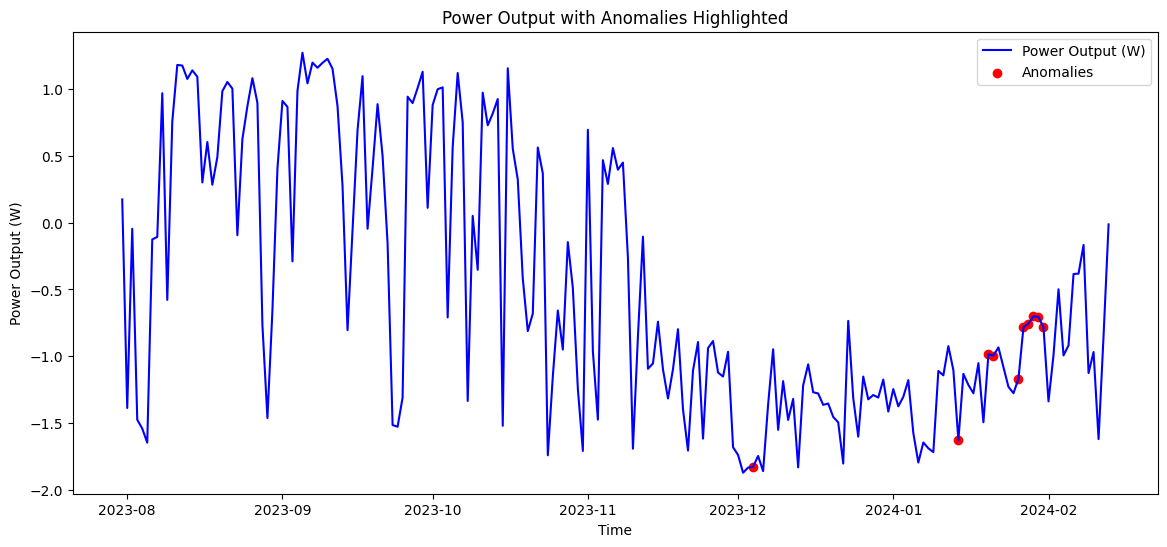

In [24]:


# Visualize anomalies in the power output
plot_anomalies(last_x_days_data, time_column='Time', value_column='Inv 1 AC-Leistung (W)', anomaly_column='anomaly')


In [25]:
# Saving the trained autoencoder model
# Define the path for saving the model
model_save_path = f'USModels/best_deep_autoencoder_model_{timesteps}.keras'
scaler_save_path = f'USModels/scaler_ae_{timesteps}.pkl'
# Save the trained model to a file
autoencoder_model.save(model_save_path)  # Save to an HDF5 file
print("Model saved to 'best_autoencoder_model.keras'")

# Save the scaler
joblib.dump(scaler, scaler_save_path)



Model saved to 'best_autoencoder_model.keras'


['USModels/scaler_ae_4.pkl']

## Import the model